<a href="https://colab.research.google.com/github/SSRaylia/Optimization/blob/master/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

We are now planning on investing in several companies based on their past stock performance. Companies include Amazon, Apple, eBay, Facebook, Google, and Twitter.The goal is to minimize risk of the portfolio with a constraint on the minimum returns.

\begin{align}
\text{Minimize} \quad \frac{1}{2} x^T & \Sigma x\\
\mu^T x &\geq R\\
\sum_{i=1}^5x_i&=1\\
x&\geq0
\end{align}



# A. Plotting the Data


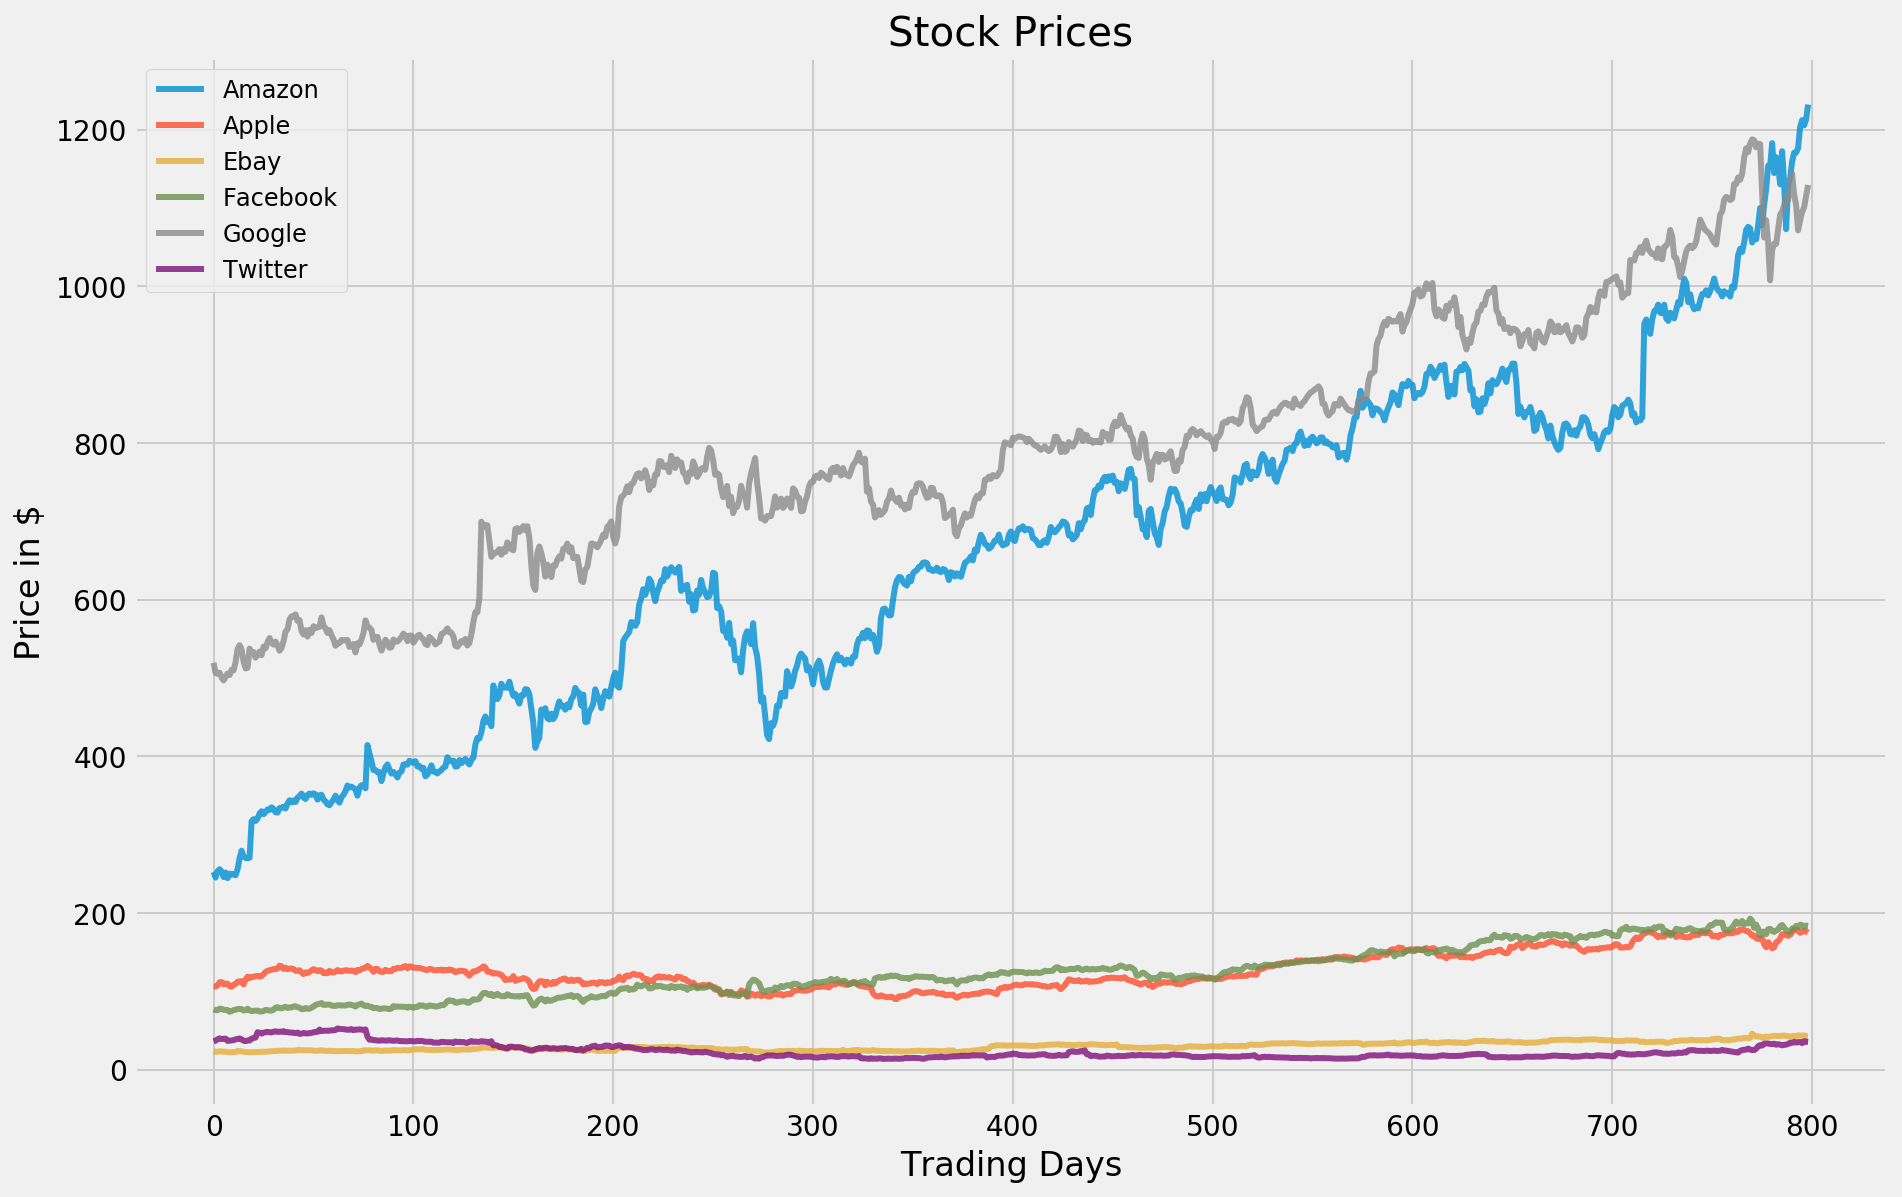

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import cvxpy as cvx
from numpy import matrix 
from cvxpy import *

%matplotlib inline

#Set Styles
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
df= pd.read_csv('https://raw.githubusercontent.com/ormarketing/finance/master/datahomework2.csv')
df.head()

plt.figure(figsize=(14,9))
for c in df.columns.values:
    plt.plot(df.index, df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.title('Stock Prices')
plt.ylabel('Price in $')
plt.xlabel('Trading Days')
plt.show()

#B. Calculate Other Parameters

## Calculate rates of returns $r_{it}$ of stock $i$ at time $t$, i.e.,

\begin{equation}
r_{it}=\frac{I_{i,t}-I_{i,t-1}}{I_{i,t-1}},
\end{equation}

where $I_{i,t}$ is the stock value at $i$ at time $t$

In [0]:
df['Amazon_rr'] = (df.Amazon-df.Amazon.shift(1))/df.Amazon.shift(1)
df['Apple_rr'] = (df.Apple-df.Apple.shift(1))/df.Apple.shift(1)
df['Ebay_rr'] = (df.Ebay-df.Ebay.shift(1))/df.Ebay.shift(1)
df['Facebook_rr'] = (df.Facebook-df.Facebook.shift(1))/df.Facebook.shift(1)
df['Google_rr'] = (df.Google-df.Google.shift(1))/df.Google.shift(1)
df['Twitter_rr'] = (df.Twitter-df.Twitter.shift(1))/df.Twitter.shift(1)
df.head()

,Amazon,Apple,Ebay,Facebook,Google,Twitter,Amazon_rr,Apple_rr,Ebay_rr,Facebook_rr,Google_rr,Twitter_rr
0,252.585,106.250000,23.457600,77.190002,519.500000,36.380001,NaN,NaN,NaN,NaN,NaN,NaN
1,245.488,106.260002,23.156700,76.150002,506.600006,37.279999,-0.028097,0.000094,-0.012827,-0.013473,-0.024832,0.024739
2,253.816,107.750000,23.116699,76.150002,505.200012,39.090000,0.033924,0.014022,-0.001727,0.000000,-0.002764,0.048552
3,256.030,111.889999,23.741699,78.175003,506.899994,40.169998,0.008723,0.038422,0.027037,0.026592,0.003365,0.027628
4,253.299,112.010002,23.413401,77.739998,500.700012,39.369999,-0.010667,0.001073,-0.013828,-0.005565,-0.012231,-0.019915


## Caculate the average return as $\mu_i$ as
\begin{equation}
\mu_i=\left(\prod_{t=1}^{T}\left(1+r_{it}   \right)      \right)^{\frac{1}{T}}-1
\end{equation}

## Which will give us th estimate of variance-covariance matrix, i.e.,

\begin{equation}
cov\left(R_i,R_j\right)=\frac{1}{T}\sum_{t=1}^{T}\left( r_{it}-\bar{r_{it}}  \right)\left( r_{jt}-\bar{r_{jt}}  \right),
\end{equation}
where
\begin{equation}
\bar{r_{it}}=\frac{1}{T}\sum_{t=1}^{T}r_{it}
\end{equation}

In [0]:
from scipy import stats
mu = stats.gmean(1+df.loc[1:,['Amazon_rr','Apple_rr','Ebay_rr','Facebook_rr','Google_rr','Twitter_rr']])-1
Cov = matrix((df.loc[1:,['Amazon_rr','Apple_rr','Ebay_rr','Facebook_rr','Google_rr','Twitter_rr']]).cov())


# C. Build Optimization Model

In [0]:
import numpy as np
from scipy.optimize import minimize

R=0.15/250

# function to calculate the risk measure (riskm)
def riskm(x):
      """This is the risk measure. 1000 is used in front of the objective function to help the algorithm converge"""
      return 1000*0.5*(np.dot(np.dot(x,Cov),x.T)) 

x_init = matrix([1/6,1/6,1/6,1/6,1/6,1/6]) # initialize the allocation vector
#x_init=x.value
cons1={'type':'eq','fun':lambda x:np.sum(x)-1}
cons2={'type':'ineq','fun':lambda x:np.dot(x,mu.T).item(0)-R}
cons=(cons1,cons2)
bnds = ((0, 1),(0, None),(0, None),(0, None),(0, None),(0, None))

# Solving the optimization problem
sol = minimize(riskm,x_init,constraints=cons,bounds=bnds, tol=1e-2)
print("The optimal allocation for each stock is\n",sol.x)
print("The objective function value is\n",sol.fun)

The optimal allocation for each stock is
 [0.2012415  0.18120927 0.17703587 0.1805459  0.18330149 0.07666596]
The objective function value is
 0.03922138793279195


In [0]:
sol

     fun: 0.03922138793279195
     jac: array([0.05417825, 0.07421048, 0.07838388, 0.07487385, 0.07211826,
       0.17875379])
 message: 'Optimization terminated successfully.'
    nfev: 9
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.2012415 , 0.18120927, 0.17703587, 0.1805459 , 0.18330149,
       0.07666596])

# Maximize Utility Function

In [0]:
import numpy as np
from scipy.optimize import minimize

# function to calculate the risk measure (riskm)
def utility(x):
      """This is the utility"""
      return -(np.dot(mu.T,x)-gamma*(np.dot(np.dot(x.T,Cov),x))) 

#x_init = matrix([1/6,1/6,1/6,1/6,1/6,1/6]) # initialize the allocation vector
K=20
x=np.zeros(6)
x[0]=K/6
x[1]=K/6
x[2]=K/6
x[3]=K/6
x[4]=K/6
x[5]=K/6
gamma=1/2
cons1={'type':'eq','fun':lambda x:np.sum(x)-1}
cons=(cons1)
bnds = ((0, None),(0, None),(0, None),(0, None),(0, None),(0, None))
# Solving the optimization problem
#sol = minimize(riskm,x,constraints=cons,bounds=bnds,method="BFGS", tol=1e-2)
sol = minimize(utility,x,constraints=(cons1),bounds=bnds, tol=1e-6)
print("The optimal allocation for each stock is\n",sol.x)
print("The objective function value is\n",-sol.fun)
sol

The optimal allocation for each stock is
 [8.94603756e-01 1.11022302e-16 4.33680869e-17 1.05396244e-01
 0.00000000e+00 0.00000000e+00]
The objective function value is
 0.0017296790736113234


     fun: -0.0017296790736113234
     jac: array([-1.62461944e-03, -6.14270102e-04, -7.40885749e-04, -1.07210026e-03,
       -9.57297860e-04, -5.48255048e-05])
 message: 'Optimization terminated successfully.'
    nfev: 144
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([8.94603756e-01, 1.11022302e-16, 4.33680869e-17, 1.05396244e-01,
       0.00000000e+00, 0.00000000e+00])

In [0]:
print(np.dot(mu.T,sol.x))
print(np.sum(sol.x))
print(sol.x)

0.0018929721568465153
1.0000000000000002
[8.94603756e-01 1.11022302e-16 4.33680869e-17 1.05396244e-01
 0.00000000e+00 0.00000000e+00]


# Minimize Risk

In [0]:
import numpy as np
from scipy.optimize import minimize

# function to calculate the risk measure (riskm)
def riskm(x):
      """This is the utility"""
      return 1000*np.dot(np.dot(x.T,Cov),x) 

#x_init = matrix([1/6,1/6,1/6,1/6,1/6,1/6]) # initialize the allocation vector
K=10
xi=np.zeros(6)
xi[0]=K/6
xi[1]=K/6
xi[2]=K/6
xi[3]=K/6
xi[4]=K/6
xi[5]=K/6
cons1={'type':'eq','fun':lambda x:np.sum(x)-1}
cons2={'type':'ineq','fun':lambda x:np.dot(mu.T,x)-R}
bnds = ((0, None),(0, None),(0, None),(0, None),(0, None),(0, None))
# Solving the optimization problem
sol = minimize(riskm,xi,constraints=(cons1,cons2),bounds=bnds)
print("The optimal allocation for each stock is\n",sol.x)
print("The objective function value is\n",-sol.fun)
sol

The optimal allocation for each stock is
 [0.20405829 0.19549683 0.16239714 0.17223547 0.19095481 0.07485746]
The objective function value is
 -0.07834704843020737


     fun: 0.07834704843020737
     jac: array([0.15661666, 0.15668938, 0.15712887, 0.15621066, 0.15690914,
       0.1565381 ])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.20405829, 0.19549683, 0.16239714, 0.17223547, 0.19095481,
       0.07485746])